In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
listing_data = pd.read_csv("./data/modelling_data")
listing_data.head()

,id,name,borough,neighbourhood,room_type_encoded,price,bathrooms,accommodates,bedrooms,beds,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",Brooklyn,Sunset Park,0,275,1.0,4,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5203,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,1,75,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,5121,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,1,60,1.0,2,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
3,5178,Large Furnished Room Near B'way,Manhattan,Midtown,1,68,1.0,2,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),Manhattan,East Harlem,1,65,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
listings = listing_data.drop(['id','name','borough','neighbourhood'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(listings.drop(columns='price'),
                                                    listings.price, test_size=0.3,
                                                    random_state=18)

In the previous step, the random forest regression with default parameters had the following performance metrics:
- R-squared: 0.46376569900475006
- RMSE: 120.93503657270503
- MAE: 68.84

I will perform a gridsearchCV to tune the parameters and calculate the new performance.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': np.arange(50,110,10),
    'max_depth': np.arange(5,25,5)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 100}
Best score: 0.5207183542299245


In [6]:
rfr = RandomForestRegressor(random_state=18)
rfr.set_params(**grid_search.best_params_)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-squared:", r2)
print("RMSE:", np.sqrt(mse))
mae = mean_absolute_error(y_test, y_pred)
print("Using these parameters, this random forest model's predictions would be off by an average of ${} from the true values".format(round(mae,2)))

R-squared: 0.4789946025395503
RMSE: 119.2054073415687
Using these parameters, this random forest model's predictions would be off by an average of $68.51 from the true values


This is a slight improvement. Will try engineering additional features.

# Engineering and adding more features 

The following are popular landmarks from each borough of New York City: <br>

- **Manhattan**: Empire State Building (40.7485° N, 73.9857° W)
- **Brooklyn**: Brooklyn Bridge (40.7061° N, 73.9969° W)
- **Queens**: Flushing Meadows-Corona Park (40.7400° N, 73.8407° W)
- **The Bronx**: Yankee Stadium (40.8296° N, 73.9262° W)
- **Staten Island**: Staten Island Ferry (40.6437° N, 74.0719° W)

In [7]:
coordinate_data = pd.read_csv('./data/coordinate_data')
coordinate_data.head()

,id,name,longitude,latitude,price,borough
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",-73.99454,40.66265,275,Brooklyn
1,5203,Cozy Clean Guest Room - Family Apt,-73.96751,40.80380,75,Manhattan
2,5121,BlissArtsSpace!,-73.95512,40.68535,60,Brooklyn
3,5178,Large Furnished Room Near B'way,-73.98317,40.76457,68,Manhattan
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),-73.94255,40.80107,65,Manhattan


In [8]:
landmarks = {
    'Manhattan': {'name': 'Empire State Building', 'lat': 40.7485, 'lon': -73.9857},
    'Brooklyn': {'name': 'Brooklyn Bridge', 'lat': 40.7061, 'lon': -73.9969},
    'Queens': {'name': 'Flushing Meadows - Corona Park', 'lat': 40.7400, 'lon': -73.8407},
    'Bronx': {'name': 'Yankee Stadium', 'lat': 40.8296, 'lon': -73.9262},
    'Staten Island': {'name': 'Staten Island Ferry', 'lat': 40.6437, 'lon': -74.0719}
}

In [9]:
import math

# defining a function to calculate the distance between a listing and its respective landmark
def haversine_distance(row):
    # getting the name and coordinate of landmark for the borough of the listing
    borough = row['borough']
    landmark_name = landmarks[borough]['name']
    landmark_lat = landmarks[borough]['lat']
    landmark_lon = landmarks[borough]['lon']

    # getting the lat and lon of the listing
    lat = row['latitude']
    lon = row['longitude']
    
    # converting the lat and lon to radians
    lat, lon, landmark_lat, landmark_lon = map(math.radians, [lat, lon, landmark_lat, landmark_lon])

    # Haversine formula
    dlon = landmark_lon - lon
    dlat = landmark_lat - lat
    a = math.sin(dlat / 2) ** 2 + math.cos(lat) * math.cos(landmark_lat) * math.sin(dlon / 2) ** 2
    c = 2 *math.asin(math.sqrt(a))
    r = 6371 # earth radius
    distance = c * r
    return distance, landmark_name

In [10]:
# Calculate the distance between each listing and its respective landmark
coordinate_data[['landmark_distance_km', 'landmark_name']] = coordinate_data.apply(haversine_distance, axis=1, result_type='expand')

In [11]:
coordinate_data.head()

,id,name,longitude,latitude,price,borough,landmark_distance_km,landmark_name
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",-73.99454,40.66265,275,Brooklyn,4.835516,Brooklyn Bridge
1,5203,Cozy Clean Guest Room - Family Apt,-73.96751,40.80380,75,Manhattan,6.336971,Empire State Building
2,5121,BlissArtsSpace!,-73.95512,40.68535,60,Brooklyn,4.210733,Brooklyn Bridge
3,5178,Large Furnished Room Near B'way,-73.98317,40.76457,68,Manhattan,1.799564,Empire State Building
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),-73.94255,40.80107,65,Manhattan,6.882754,Empire State Building


In [12]:
listing_data.head()

,id,name,borough,neighbourhood,room_type_encoded,price,bathrooms,accommodates,bedrooms,beds,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",Brooklyn,Sunset Park,0,275,1.0,4,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5203,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,1,75,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,5121,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,1,60,1.0,2,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
3,5178,Large Furnished Room Near B'way,Manhattan,Midtown,1,68,1.0,2,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,6872,Uptown Sanctuary w/ Private Bath (Month to Month),Manhattan,East Harlem,1,65,1.0,1,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
df_df = pd.merge(listing_data, coordinate_data[['landmark_distance_km','id']], on=['id'], how='left')

In [14]:
df = df_df.drop(["id","name", "borough", "neighbourhood"], axis=1)

In [15]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [16]:
param_grid = {
    'n_estimators': np.arange(50,110,10),
    'max_depth': np.arange(5,25,5)
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 100}
Best score: 0.5449365349267903


As this Grid Search produced a better score than the previous, I will use the new best parameters.

In [17]:
rfr = RandomForestRegressor(random_state=18)
rfr.set_params(**grid_search.best_params_)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [18]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-squared:", r2)
print("RMSE:", np.sqrt(mse))
mae = mean_absolute_error(y_test, y_pred)
print("This random forest model's predictions would be off by an average of ${} from the true values".format(round(mae,2)))

R-squared: 0.5170204167335457
RMSE: 114.77286719744308
This random forest model's predictions would be off by an average of $66.91 from the true values


This model's performance has been the best so far. 

Finally, I'll try the popular gradient boosting model with XGBoost to see if it improves upon the RandomForest.

In [19]:
import xgboost as xgb

# Define the parameter grid to search over
param_grid = {
    'max_depth': np.arange(3,8),
    'learning_rate': [0.01, 0.05, 0.1,0.3],
    'n_estimators': [50,100,200]
}

# Use GridSearchCV to search over the parameter grid
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(), 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


In [21]:
# Fit the grid search object to the training data
xgb_reg = xgb.XGBRegressor(**grid_search.best_params_)
xgb_reg.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")
print("The best model's predictions would be off by an average of ${} from the true values".format(round(mae,2)))

Root mean squared error: 113.20814741076195
The best model's predictions would be off by an average of $66.22 from the true values


So the performance improved with the XGB model. The best model is the XGB with the added landmark proximity feature.

## Feature Analysis

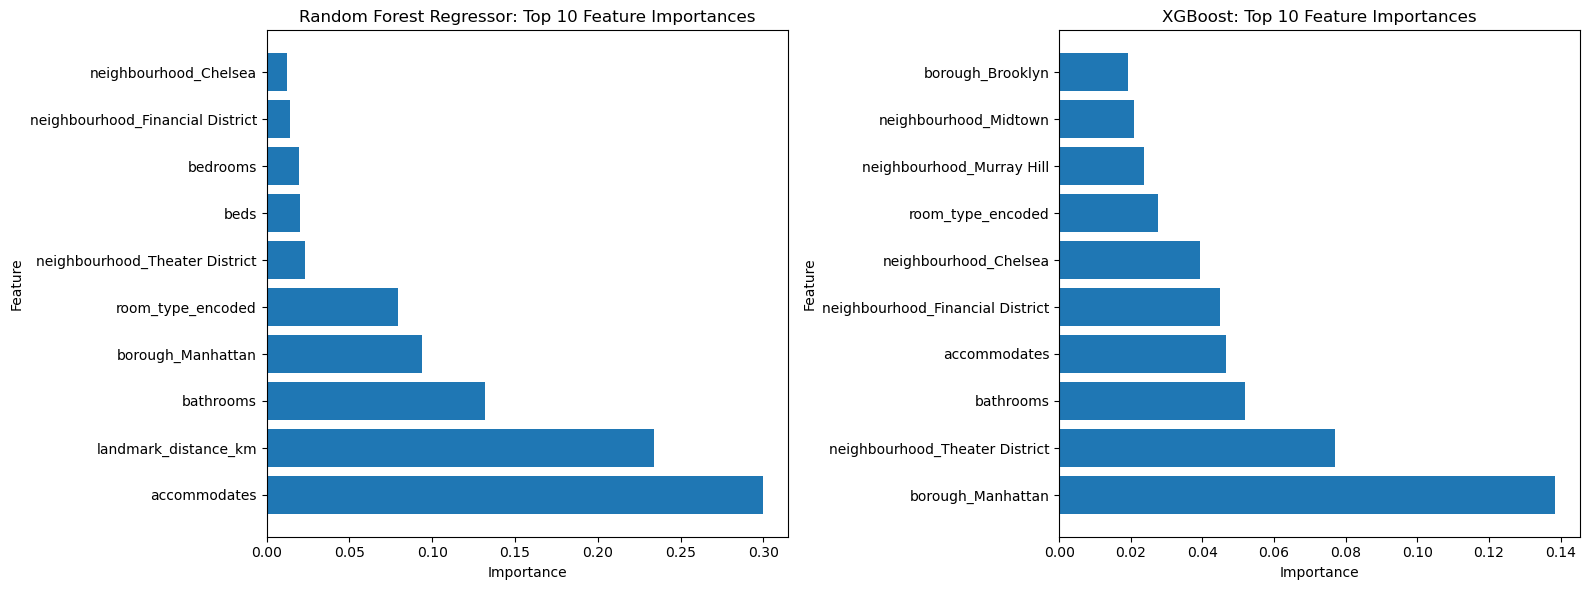

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances for Random Forest Regressor
importances_rfr = rfr.feature_importances_
indices_rfr = np.argsort(importances_rfr)[::-1]
top_features_rfr = 10
indices_rfr = indices_rfr[:top_features_rfr]
importances_rfr = importances_rfr[indices_rfr]
feature_names_rfr = X_train.columns[indices_rfr]

# Get feature importances for XGBoost
importances_xgb = xgb_reg.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
top_features_xgb = 10
indices_xgb = indices_xgb[:top_features_xgb]
importances_xgb = importances_xgb[indices_xgb]
feature_names_xgb = X_train.columns[indices_xgb]

# Set up the figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot feature importances for Random Forest Regressor
axes[0].barh(range(len(indices_rfr)), importances_rfr, align='center')
axes[0].set_yticks(range(len(indices_rfr)))
axes[0].set_yticklabels(feature_names_rfr)
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')
axes[0].set_title('Random Forest Regressor: Top 10 Feature Importances')

# Plot feature importances for XGBoost
axes[1].barh(range(len(indices_xgb)), importances_xgb, align='center')
axes[1].set_yticks(range(len(indices_xgb)))
axes[1].set_yticklabels(feature_names_xgb)
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')
axes[1].set_title('XGBoost: Top 10 Feature Importances')

plt.tight_layout()
plt.show()

## Profitability Analysis

To do this, I will need to make the naive assumption that the company's model current model is average price using neighbourhood and beds.

Then I will conduct a comparison of the profitability by considering different scenarios.

First, I will by assuming a potential decrease in bookings when my predicted price is higher than the company's assumption. Next I will:

- Calculate the profitability of my model's predictions taking into account the potential decrease in bookings.

- Calculate the profitability of the company's model (mean price for neighbourhood & beds) without considering any decrease in bookings.

- Compare profitability results by calculating the difference in profits between the two scenarios.

Finally, I will analyze the profit difference to understand the impact of my model's predictions. 

If the profit difference is positive, that indicates my model's predictions generates higher profit despite the potential decrease in bookings.

In [23]:
#get X_test indices
indices = X_test.index
X_test_subset = df_df.loc[indices].copy()

In [24]:
X_test_subset['predicted_price'] = y_pred

In [25]:
# or should I use neighbourhood and room_type?
X_test_subset['naive_price'] = X_test_subset.groupby(['neighbourhood', 'beds'])['price'].transform('mean')

In [26]:
#X_test_subset[["price", "predicted_price", "naive_price"]]

PART 2

In [27]:
from datetime import datetime

df_occupancy = pd.read_csv("./data/source/calendar.csv.gz", low_memory=False)
df_occupancy.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5136,2022-12-04,f,$275.00,$275.00,21.0,1125.0
1,2595,2022-12-05,t,$175.00,$175.00,30.0,1125.0
2,2595,2022-12-06,t,$175.00,$175.00,30.0,1125.0
3,2595,2022-12-07,t,$175.00,$175.00,30.0,1125.0
4,2595,2022-12-08,t,$175.00,$175.00,30.0,1125.0


In [28]:
df_occupancy['date'] = pd.to_datetime(df_occupancy['date'])

In [29]:
available_listings = df_occupancy[df_occupancy['available'] == 't']
available_days = available_listings.groupby('listing_id')['date'].nunique().reset_index()
available_days.rename(columns={'date': 'available_days'}, inplace=True)
available_days.head()

,listing_id,available_days
0,2595,365
1,5121,322
2,5136,267
3,5178,79
4,5803,163


In [30]:
total_days = df_occupancy.groupby('listing_id')['date'].nunique().reset_index()
total_days.rename(columns={'date': 'total_days'}, inplace=True)

In [31]:
occupancy = pd.merge(total_days, available_days, on='listing_id')
occupancy['occupancy_rate'] = ((occupancy['total_days'] - occupancy['available_days']) / occupancy['total_days']) * 100

In [32]:
merged = pd.merge(occupancy[['occupancy_rate','listing_id']], X_test_subset, left_on='listing_id', right_on='id')

In [33]:
constant_adjustment = 0.9
# calculate gross profit for my predictions
def calculate_gross_profit(row):
    if row['predicted_price'] > row['naive_price']:
        return row['occupancy_rate'] * row['predicted_price'] * constant_adjustment
    else:
        return row['occupancy_rate'] * row['naive_price']

In [34]:
# My predicted gross profit
merged['model_gross_profit'] =  merged.apply(calculate_gross_profit, axis=1)

# Naive gross profit
merged['naive_gross_profit'] = merged['occupancy_rate'] * merged['naive_price']

In [39]:
total_predicted_profit = merged['model_gross_profit'].sum()

total_naive_profit = merged['naive_gross_profit'].sum()

if total_predicted_profit > total_naive_profit:
    print("My model is more profitable and will generate ${} more in profit for the assessed listings in one year".format(round(total_predicted_profit - total_naive_profit)))
else:
    print("The naive model is more profitable")



My model is more profitable and will generate $4581429 more in profit for the assessed listings in one year


# NEXT STEPS

#### 1. Additional feature engineering:
  - Using `amenities` as an additional feature.
  - Using another encooding method for `room_type`
  - Using different landmarks - possibly extracted from the `name` feature if available


#### 2. Apply models on other cities 

